In [1]:
%load_ext autoreload
%autoreload 2

In this notebook we are analyzing the data calculated in nb 03 in order to look into possible Blazhko stars.

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [3]:
#| code-fold: false
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
from descriptive_stats import *
from plots import *

from selection import *
from lc_analysis import *

Loading the data!


In [5]:
#| code-fold: false
# DATA
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

# Loading the data

After finishing the preliminary setup, it's time to load the fit data, periodograms and light curve data.

In [6]:
#| code-fold: false
lightcurve_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINAL.csv')
lightcurve_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPztf_chi2dofR,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,3.645075,0.052598,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,1.162370,0.031558,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,3.137436,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,1.556614,0.020152,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25
4,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,1.341415,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25


In [7]:
#| code-fold: false
periodograms = pickle.load(open("../outputs/periodograms_final.pkl", "rb"))

In [8]:
#| code-fold: false
FITS = np.load('../outputs/fits_whole.npy', allow_pickle=True)

# Statistical analysis of data

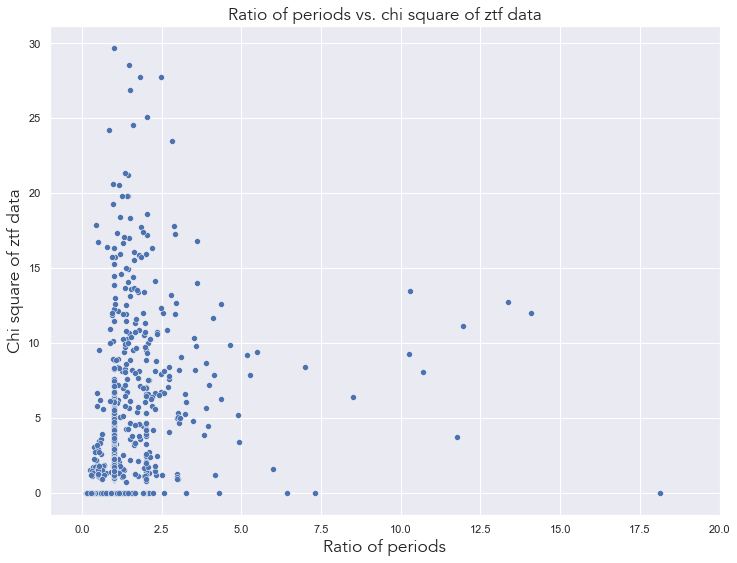

In [9]:
#| label: fig_pratio_vs_chiztf
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of ZTF light curves
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Pratio', y='ZPztf_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of ztf data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of ztf data', fontproperties=font)
plt.show()

From the graph above we can see that most ratios of periods focus around the 1 mark, with chi quare values increasing along that line. There is another line present which indicates 0 chi square and increasing ratio of periods. The rest of the data is scattered on the graph.

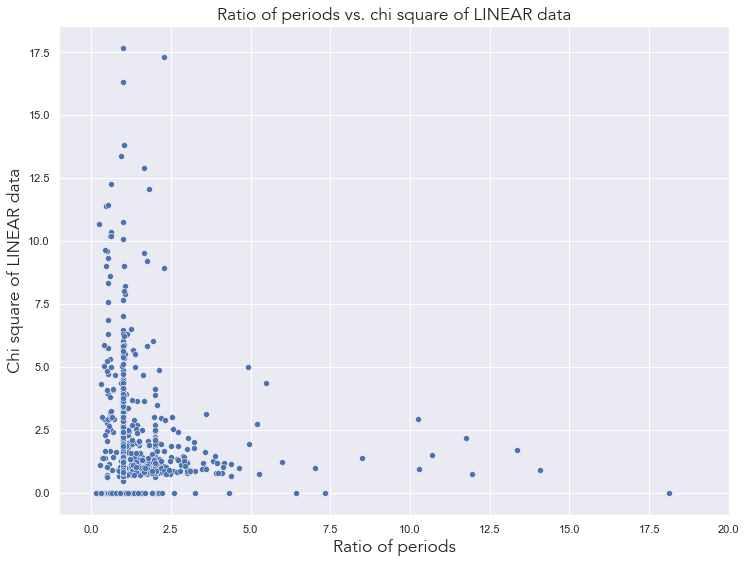

In [10]:
#| label: fig_pratio_vs_LINEARchi
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of LINEAR light curves
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Pratio', y='LPlin_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of LINEAR data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of LINEAR data', fontproperties=font)
plt.show()

From the graph above, we can see the same pattern as with the ZTF data, showing that they are actually quite similar. However, more ratios of periods are scattered near the lower end of the graph (smaller chi values).

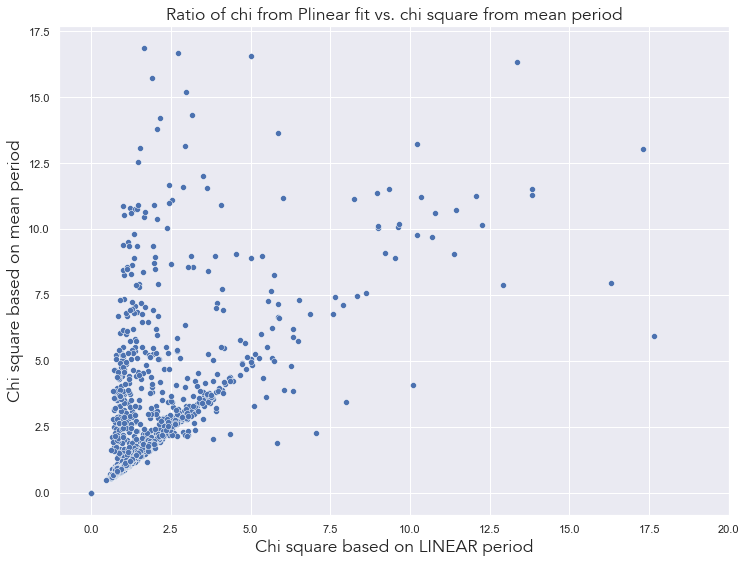

In [11]:
#| label: fig_chiL_vs_chiLmean
#| fig-cap: The chi value based on the fit from the LINEAR period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='LPlin_chi2dofR', y='LPmean_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of chi from Plinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on LINEAR period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

As expected, most values fall on a diagonal line indicating that they should be the same, however a sizeable fraction isn't the same as the mean value, indicating that the `ZTF` period is pushing the mean towards a different direction than the original `LINEAR` period.

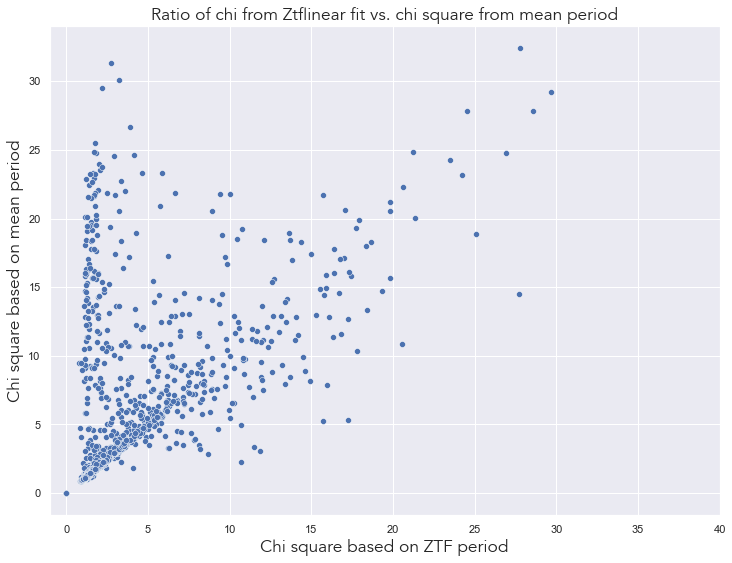

In [12]:
#| label: fig_chiZ_vs_chiZmean
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='ZPztf_chi2dofR', y='ZPmean_chi2dofR')
plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

From the graph above we can also see a diagonal line indicating equality, however the data is slightly more scattered than in the `LINEAR` graph. 

- cut na 20-30 tocaka na broj tocaka podataka -> nacrtati histogram za procjeniti koliko treba maknuti tocaka
- odrediti kvalitetne podatke, odbaciti ostalo
- *koliko smo izgubili losih podataka*
- izrezati zvijezde iz dijagrama ispod i analizirati neobicne zvijezde
- napraviti nacin kako uzeti samo dobre zvijezde, nekako automatski proci vizualno kroz krivulje
- analizirati manji probrani sample za blahko effect
- nacrtati dijagram koji usporeduje razlike izmedu chi mean i chi best period za linear i ztf i obojati tocke bazirano na broju tocaka

In [13]:
lightcurve_analysis['Chi_diff_LINEAR'] = lightcurve_analysis['LPmean_chi2dofR'] - lightcurve_analysis['LPlin_chi2dofR'] 

In [14]:
lightcurve_analysis['Chi_diff_ZTF'] = lightcurve_analysis['ZPmean_chi2dofR'] - lightcurve_analysis['ZPztf_chi2dofR'] 

In [15]:
lightcurve_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Chi_diff_LINEAR,Chi_diff_ZTF
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25,0.159324,0.310458
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25,0.008459,0.014946
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.028766,0.151069
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25,0.008148,0.024178
4,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,0.005548,0.173992


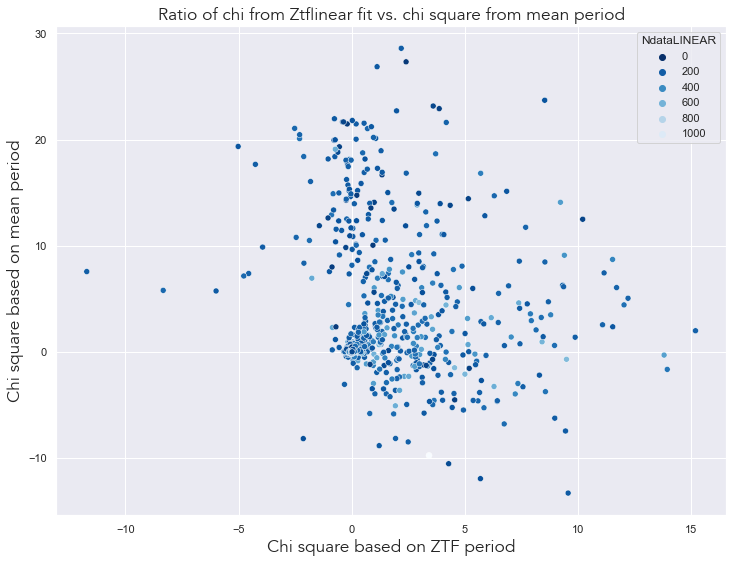

In [16]:
#| label: fig_diff_chi_NdataLinear
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Chi_diff_LINEAR', y='Chi_diff_ZTF', hue='NdataLINEAR', palette='Blues_r')
#plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

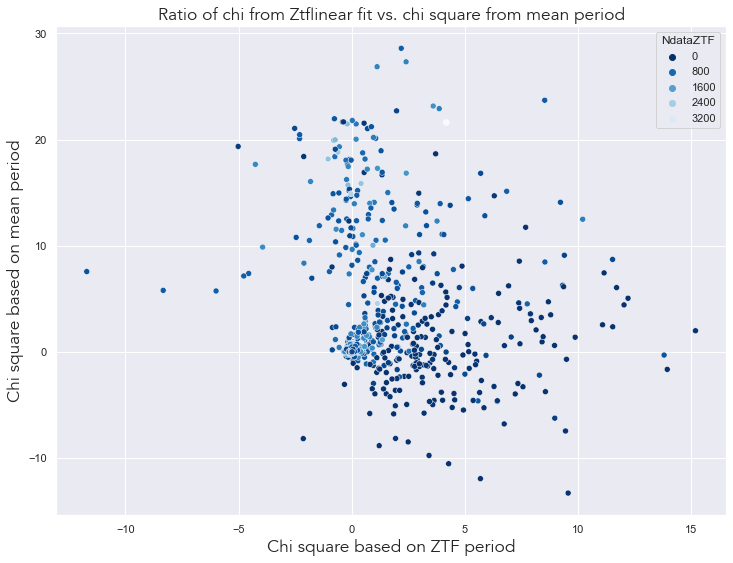

In [17]:
#| label: fig_diff_chi_NdataZtf
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Chi_diff_LINEAR', y='Chi_diff_ZTF', hue='NdataZTF', palette='Blues_r')
#plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

Based on these graphs, we can cut all light curves which have less than 40 datapoints, so that we can work with a cleaner sample.

In [18]:
#| code-fold: false
lightcurve_analysis = lightcurve_analysis.loc[(lightcurve_analysis['NdataLINEAR'] > 40) | (lightcurve_analysis['NdataZTF'] > 40)]
print(lightcurve_analysis.shape)

(2516, 29)


In [19]:
#| code-fold: false
lightcurve_analysis['Pratio'] = round(lightcurve_analysis['Pratio'], 4)
lightcurve_analysis['Ampl_diff'] = round(abs(lightcurve_analysis['Lampl'] - lightcurve_analysis['Zampl']), 3)
lightcurve_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
0,29848,0.557021,0.557037,0.557029,1.0,301.0,0.178198,3.028026,1.451336,0.185326,...,3.955532,15.756993,0.925157,0,0.25,0.0,0.25,0.159324,0.310458,0.358
1,50402,0.643301,0.643296,0.643298,1.0,284.0,0.107683,0.595738,0.733869,0.106092,...,1.177316,16.088901,0.486372,0,0.25,0.0,0.25,0.008459,0.014946,0.001
2,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.934727,0.114002,...,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.028766,0.151069,0.017
3,91437,0.674732,0.674738,0.674735,1.0,177.0,0.040798,2.775415,1.352923,0.040888,...,1.580792,15.002323,0.864724,0,0.25,0.0,0.25,0.008148,0.024178,0.004
4,95250,0.313870,0.313876,0.313873,1.0,222.0,0.162040,0.816590,0.859616,0.165801,...,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,0.005548,0.173992,0.022


In [20]:
#| code-fold: false
print(lightcurve_analysis.shape)

(2516, 30)


We have effectively removed 194 stars from our dataset due to the insufficient amount of data. We can now proceed on to further analysis.

# Filtering the data for Blazhko candidates

### Creating a dataset with all possible Blazhko candidates

The next step is to create a dataset where at least one of the many criteria for Blazhko stars is met. 

The parameters:

1. <span style="color:CadetBlue">Ratio of Periods</span>: must be below 0.99 and above 1.01 (when rounded to 2 decimals).

2. <span style="color:CadetBlue">Chi square</span>: has to be above 3 for a significant change for the Blazhko effect.

3. <span style="color:CadetBlue">Indicator from periodogram</span>: `Zindicator` and `Lindicator` should be 1 (however in other situations one or the either can be 1).

4. <span style="color:CadetBlue">Amplitude</span>: if the amplitude change is greater than 0.01.

In [21]:
#| code-fold: false
# PARAMETER VALUES
chi = 3.0
pratio_less = 0.99
pratio_more = 1.01
ampl = 0.01

In [22]:
lightcurve_criterium = lightcurve_analysis.loc[((lightcurve_analysis['Lindicator'] != 0) | 
                                             (lightcurve_analysis['Zindicator'] != 0.0))]
lightcurve_criterium = lightcurve_criterium.loc[((lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] > chi)) | 
                                             ((lightcurve_analysis['Pratio'] > pratio_less) | 
                                             (lightcurve_analysis['Pratio'] < pratio_more)) |
                                             (lightcurve_analysis['Ampl_diff'] > ampl)]
print(f'This dataset has {lightcurve_criterium.shape[0]} rows and {lightcurve_criterium.shape[1]} columns.')
lightcurve_criterium.head()

This dataset has 806 rows and 30 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
2,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.934727,0.114002,...,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.028766,0.151069,0.017
4,95250,0.313870,0.313876,0.313873,1.0,222.0,0.162040,0.816590,0.859616,0.165801,...,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,0.005548,0.173992,0.022
7,136668,0.532922,0.532929,0.532926,1.0,310.0,0.122892,1.639568,1.114588,0.121226,...,2.478210,16.107864,0.775380,1,0.25,0.0,0.25,-0.038400,0.168693,0.046
9,142794,0.470787,0.470804,0.470796,1.0,270.0,0.095738,1.814911,0.991759,0.100813,...,3.570589,15.745773,0.815178,1,0.25,0.0,0.25,0.048320,-0.063895,0.093
12,163933,0.339629,0.339626,0.339628,1.0,306.0,0.064185,0.972501,0.882843,0.066518,...,1.002086,15.262747,0.463487,1,0.25,0.0,0.25,0.039070,-0.048520,0.014


It turns out that all of our light curves exhibit at least one of these factors! This means that it is necessary to go through each light curve, one by one, and decide wether it goes into the Blazhko pile or not.

## Building an interface for distinguishing Blazhko stars

The interface is going to loop through every light curve in our filtered dataset, and plot 6 graphs of the data, the `LINEAR` fits, `ZTF` fits and the periodograms. Above, the main and important information is going to be printed about each light curve, or the criteria we specified above. Below, there are going to be 2 buttons: the `CONTINUE` and `KEEP` button. The `CONTINUE` button signals the for loop to continue running, essentially discarding the light curve as not a Blazhko star. The `KEEP` button however, takes the current row of the dataset and concatenates it with our `BLAZHKO_STARS` DataFrame. After saving our light curve, we click `CONTINUE` again to continue the for loop. 

- runnaj kod od 190te svjetlosne krivulje pa nadalje

In [24]:
#| code-fold: false
# DEFINING CONSTANTS AND CONFIGURATION FOR INTERFACE
# ----------------------------------------------------
test = lightcurve_criterium.shape[0]
dataset = lightcurve_criterium
ids = dataset['LINEAR id'].to_numpy()
chi_L = dataset['LPlin_chi2dofR'].to_numpy()
chi_Z = dataset['LPlin_chi2dofR'].to_numpy()
pratio = dataset['Pratio'].to_numpy()
L, Z = dataset['Lindicator'].to_numpy(), dataset['Zindicator'].to_numpy()
ampl = dataset['Ampl_diff'].to_numpy()

# DATAFRAME for storing Blazhko candidates
blazhko_list = pd.DataFrame(())

In [25]:
#| code-fold: false
current_i = None  # Initialize current_i

def plot_light_curves(test):
    '''
    For loop for plotting all desired light curves.

    test(int) = number of times to go through the for loop
    '''
    global current_i # set up current_i as a global variable
    for i in range(test): # define the main for loop
        current_i = i
        LID = ids[i]
        blazhko_analysis(lightcurve_criterium, Lid=LID, order=i, PD=periodograms, fits=FITS) # plot all necessary plots
        yield # wait for button click to continue

gen = plot_light_curves(test) # setup object for function

button_keeping = widgets.Button(description='Keep') # keep button
button_continue = widgets.Button(description='Continue') # continue button

# set up output for plots (making them visible)
output_plot = widgets.Output()

# define what happens when continue is clicked
def on_continue_click(b):
    global current_i # remember what current_i is since it is a global variable and can be changed and updated
    with output_plot: # clear previous plot
        clear_output(wait=True)
        try:
            next(gen) # go to next i value (plot next plot.)
        except StopIteration: # when loop is finished
            print("No more plots.")
            button_continue.disabled = True # disable button

# define what happens when keep is clicked
def on_keep_click(b):
    global blazhko_list # make this table global so it can be updated and changed
    row = pd.DataFrame(dataset.iloc[[int(current_i)]]) # find the row for that specific i (current_i)
    blazhko_list = pd.concat([blazhko_list, row], ignore_index=True, axis=0) # concatenate it with the BLAZHKO_STARS dataframe

# define that clicking keep corresponds to the function on_keep_click
button_keeping.on_click(on_keep_click)
# define that clicking continue corresponds to the function on_continue_click
button_continue.on_click(on_continue_click)

# display everything organized as plot - keep - continue
display(output_plot, button_keeping, button_continue)

on_continue_click(None) # begin the loop

Output()

Button(description='Keep', style=ButtonStyle())

Button(description='Continue', style=ButtonStyle())

In [72]:
blazhko_list.shape

(142, 30)

In [73]:
name = 'ED'
blazhko_list.to_csv("../outputs/BLAZHKO_LIST_"+name+".csv", index=False)

In [74]:
current_i

615

### Joining the 2 datasets if you have more than 1

In [94]:
blazhko = pd.read_csv('../outputs/BLAZHKO_STARS.csv')
blazhko_2 = pd.read_csv('../outputs/BLAZHKO_STARS_part2.csv')

In [95]:
blazhko.shape, blazhko_2.shape

((89, 30), (142, 30))

In [96]:
blazhko_list = pd.concat([blazhko, blazhko_2], ignore_index=True, axis=0)

# Blazhko candidates

In [ ]:
blazhko

In [97]:
blazhko_list.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
0,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.934727,0.114002,...,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.028766,0.151069,0.017
1,136668,0.532922,0.532929,0.532926,1.0,310.0,0.122892,1.639568,1.114588,0.121226,...,2.478210,16.107864,0.775380,1,0.25,0.0,0.25,-0.038400,0.168693,0.046
2,163933,0.339629,0.339626,0.339628,1.0,306.0,0.064185,0.972501,0.882843,0.066518,...,1.002086,15.262747,0.463487,1,0.25,0.0,0.25,0.039070,-0.048520,0.014
3,516954,0.297570,0.297569,0.297569,1.0,243.0,0.184932,5.571245,2.367995,0.183362,...,1.297153,15.634764,0.417715,1,0.25,0.0,0.25,0.004314,-0.016976,0.106
4,523832,0.372376,0.372384,0.372380,1.0,251.0,0.101045,1.778302,1.177467,0.103623,...,1.131261,15.358163,0.434539,1,0.25,0.0,0.25,0.072532,-0.123884,0.014


In [98]:
blazhko_list.shape

(231, 30)

In [99]:
blazhko_list = blazhko_list.drop_duplicates(subset=['LINEAR id'], keep='first')

In [100]:
blazhko_list.shape

(192, 30)

In [101]:
blazhko_list.to_csv("../outputs/BLAZHKO_LIST_ED.csv", index=False)

So, it turns out that during our analysis there have been 39 duplicates! This might be due to clicking the `Continue` button twice by accident or during the joining process, when the second table was created the light curves started a bit earlier (although this constitutes 1-2 stars).